In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
import emcee, corner
from analyzeradprofile import *
from scipy.optimize import minimize

In [2]:
def lnlike(ellipse_params, x, y, cosi, par):
    """
    Parameters
    ==========
    ellipse_params: Tuple of ellipse parameters to fit for: x0, y0, r0, cosi, par, logvar
                    x0: x-offset in arcsec (Eastward offset is positive)
                    y0: y-offset in arcsec (Northward offset is positive)
                    r0: Radius of deprojected ring (arcsec)
                    logvar: Logarithm of variance of orthogonal distance from true ellipse (variance in arcsec^2)
    
    x: Array of x-coordinates to fit (in arcsec)
    y: Array of y-coordinates to fit (in arcsec)    
    
    Returns
    =======
    Log-likelihood of the data given the ellipse model
    """
    x0, y0, r0, logvar = ellipse_params
    assert len(x)==len(y)
    a = r0
    b = r0*cosi
    theta = par-np.pi/2.
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    A = (costheta/a)**2+(sintheta/b)**2
    B = -2*costheta*sintheta/a**2+2*costheta*sintheta/b**2
    C = (sintheta/a)**2+(costheta/b)**2
 
    e0 = B**2-4*A*C #scalar
    e1 = 2*B*e0 #scalar
    e2 = 2*C*e0*(y-y0) #vector
    e3 = 4*B*C #scalar
    e4 = B**2+4*C**2+e0 #scalar
    e5 = 2*C*(B*(y-y0)-2*C*(x-x0)) #vector
    f4 = e1**2-e0*e4**2 #scalar
    f3 = 2*e1*e2-2*e0*e4*e5 #vector
    f2 = e2**2+2*e1*e3-e0*e5**2-4*e4**2*C #vector
    f1 = 2*e2*e3-8*e4*e5*C #vector
    f0 = e3**2-4*e5**2*C #vector
    sumdsq = 0 #sum of the squared orthogonal distances from the model ellipse
    #find the point p on the ellipse such that the tangent line is orthogonal to the line connecting p and the datapoint
    for i in range(len(x)):
        dmin = 1.e10
        #we get a fourth-order polynomial, but only one of the roots corresponds to the actual distance (the real root that minimizes the distance)
        roots = np.roots(np.array([f4, f3[i], f2[i], f1[i], f0[i]]))

        for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
            xi = (e1*dx**2+e2[i]*dx+e3)/(e4*dx+e5[i])
            dy = (-B*dx+xi)/(2*C)
            dist = np.sqrt((x[i]-x0-dx)**2+(y[i]-y0-dy)**2)
            if dist<dmin:
                dmin = dist       
        sumdsq+=dmin**2
    n = len(x)
    inv_sigma2 = 1.0/np.exp(logvar)
    return -0.5*(inv_sigma2*sumdsq - n*np.log(inv_sigma2))

def ellipse_mle(starting_guess, xcoord, ycoord, cosi, par, quiet = False):
    mle = minimize(lambda *args: -lnlike(*args), starting_guess, args = (xcoord, ycoord, cosi, par),method = 'Nelder-Mead')
    result = mle["x"]
    if not quiet:
        print("The MLE offsets are delta_x = %.3e arcsec, delta_y = %.3e arcsec" % (result[0], result[1]))
        print("The MLE semi-major axis is r = %.3f arcsec" % (result[2],))
        print("The MLE log-variance in the pixel offsets from the true ellipse is %.3e" % (result[3],)) 
    return result

def run_mcmc(nwalkers, nthreads, nsteps, initial_pos, lnprob, xcoord, ycoord, cosi, par):
    ndim = 4
    starting_pos = [initial_pos + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xcoord, ycoord, cosi,par), threads = nthreads)
    sampler.run_mcmc(starting_pos, nsteps)

    return sampler

def plot_corner(sampler, burnin, skip):
    ndim = sampler.chain.shape[2]
    samples = sampler.chain[:, burnin::skip, :].reshape((-1, ndim))
    fig = corner.corner(samples,  labels=["x0", "y0", "r0", "logvar"], quantiles = [0.16, 0.5, 0.84], show_titles = True, title_fmt = ".4f")
    plt.show()
    
def sampler_results(sampler, burnin, distance):
    samples = sampler.chain[:, burnin:, :].reshape((-1, 4))
    median = np.percentile(samples, 50, axis = 0)
    sixteenth = np.percentile(samples, 16, axis = 0)
    eightyfourth = np.percentile(samples, 84, axis = 0)
    
    print("The x offset is delta_x = %.2e arcsec (+%.1e, -%.1e)"  % (median[0], eightyfourth[0]-median[0], median[0]-sixteenth[0]))
    print("The y offset is delta_y = %.2e arcsec (+%.1e, -%.1e)" % (median[1], eightyfourth[1]-median[1], median[1]-sixteenth[1]))
    print("The median semi-major axis is r = %.4f arcsec (+%.4f, -%.4f) \nor %.2f AU (+%.2f, -%.2f)" % 
          (median[2],eightyfourth[2]-median[2], median[2]-sixteenth[2],median[2]*distance,distance*(eightyfourth[1]-median[1]), distance*(median[1]-sixteenth[1])))
    print("The median log-variance in the pixel offsets from the true ellipse is %.3e" % (median[3],)) 

def find_profile_extrema(radbins, radprofile, extrema = 'max'):    
    grad = np.gradient(radprofile)
    if extrema=='max':
        sgn_chg = np.where((np.sign(grad[:-1])!=np.sign(grad[1:])) & (np.sign(grad[:-1])>0))[0]
    else:
        sgn_chg = np.where((np.sign(grad[:-1])!=np.sign(grad[1:])) & (np.sign(grad[:-1])<0))[0]
    locs = []
    for i in sgn_chg:
        if np.abs(grad[i])>np.abs(grad[i+1]):
            locs.append(i+1)
        else:
            locs.append(i)
    return locs


In [3]:
disk =  {'filename': '/data/sandrews/jhfiles/TWHya/TWHya_newreduction/reduction_all/B6B7_cont.image.tt0.fits',
                          'name': 'TW Hya', 
                          'distance':60,
                          'incl' : 7, #from Qi et al 2004
                          'PA' : 155, #from Qi et al 2004
                          'offsetx' : 0.01, 
                          'offsety' : .015,
                          'size': 2.5,
                          'gamma': 1.0
                         }


In [14]:


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
maxrad = 100
radialbins = 0.25+0.5*np.arange(2*maxrad)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


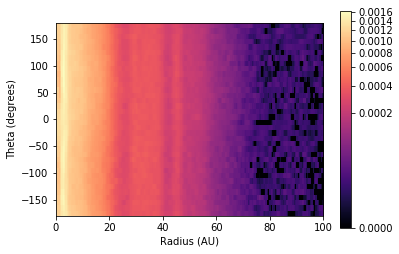

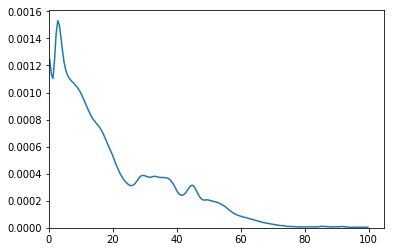

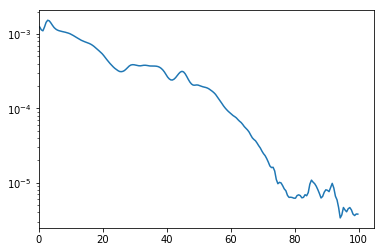

In [10]:


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])

surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.2, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.show()

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


The MLE offsets are delta_x = 9.100e-03 arcsec, delta_y = 1.301e-02 arcsec
The MLE semi-major axis is r = 0.427 arcsec
The MLE log-variance in the pixel offsets from the true ellipse is -8.643e+00


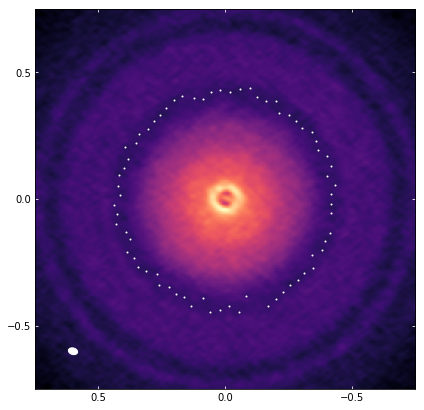

In [11]:

# Extract the gap that's at ~25 AU
xcoords1, ycoords1 = cont.extract_ring(22,28,tbins = -177.5+5*np.arange(72), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 1.0, 1.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     25/60., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1,
                    np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180.)

In [37]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord, cosi, par):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord,cosi,par)


nwalkers = 30
nthreads = 8
nsteps = 20000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1, np.cos(7*np.pi/180.), 155*np.pi/180.)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anacond

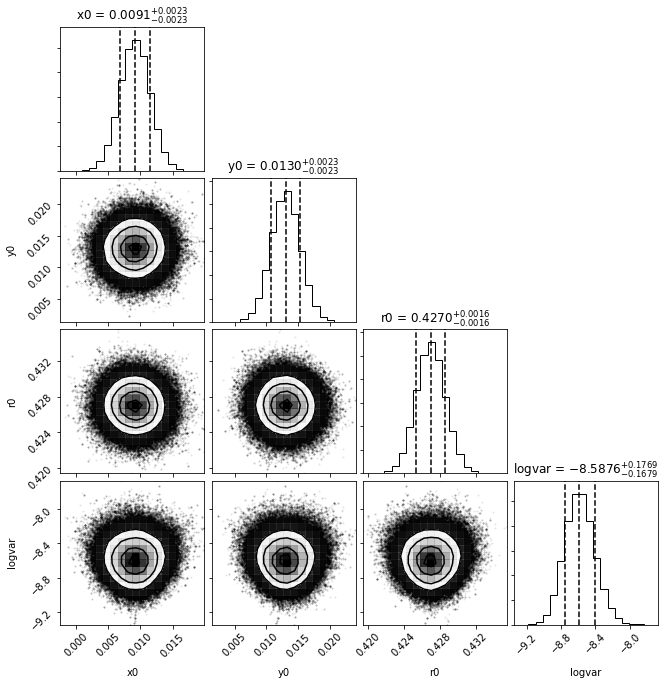

The x offset is delta_x = 9.12e-03 arcsec (+2.3e-03, -2.3e-03)
The y offset is delta_y = 1.30e-02 arcsec (+2.3e-03, -2.3e-03)
The median semi-major axis is r = 0.4270 arcsec (+0.0016, -0.0016) 
or 25.62 AU (+0.14, -0.14)
The median log-variance in the pixel offsets from the true ellipse is -8.588e+00


In [38]:
plot_corner(sampler1, 1000, 1)
sampler_results(sampler1, 1000, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


The MLE offsets are delta_x = 8.219e-03 arcsec, delta_y = 1.366e-02 arcsec
The MLE semi-major axis is r = 0.694 arcsec
The MLE log-variance in the pixel offsets from the true ellipse is -8.941e+00


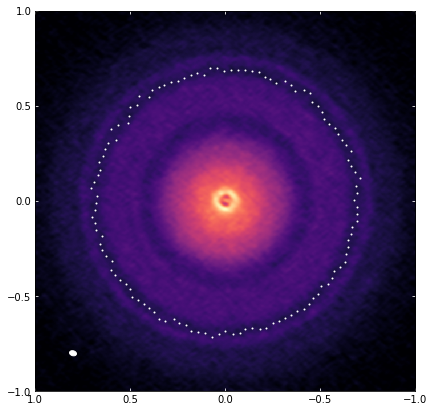

In [28]:

# Extract the gap that's at ~42 AU
xcoords2, ycoords2 = cont.extract_ring(39,45,tbins = -178.5+3*np.arange(120), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 1.0, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     40/60., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2,
                    np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180.)

In [41]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2, np.cos(7*np.pi/180.), 155*np.pi/180.)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anacond

In [42]:
np.savez("TWHyaellipsechains.npz", DA26 = sampler1.chain, DA42 = sampler2.chain)

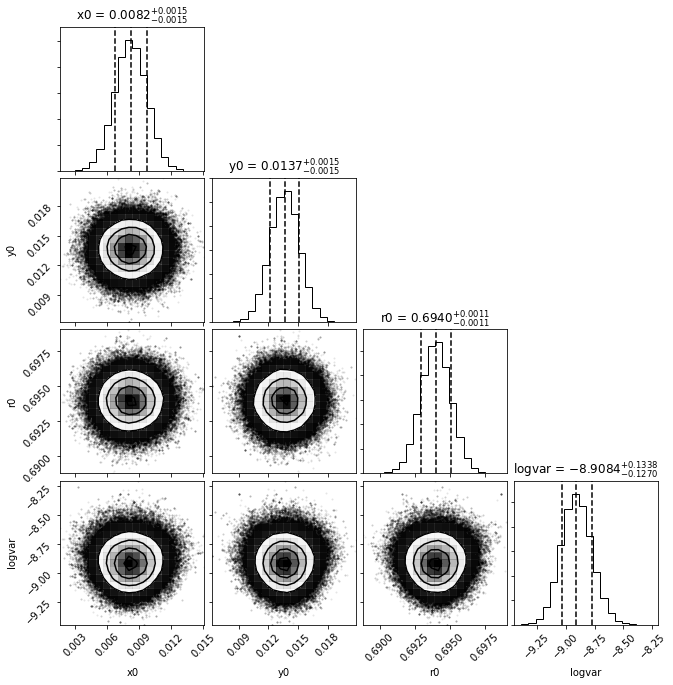

The x offset is delta_x = 8.21e-03 arcsec (+1.5e-03, -1.5e-03)
The y offset is delta_y = 1.37e-02 arcsec (+1.5e-03, -1.5e-03)
The median semi-major axis is r = 0.6940 arcsec (+0.0011, -0.0011) 
or 41.64 AU (+0.09, -0.09)
The median log-variance in the pixel offsets from the true ellipse is -8.908e+00


In [43]:
plot_corner(sampler2, 1000, 1)
sampler_results(sampler2, 1000, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


The MLE offsets are delta_x = 6.819e-03 arcsec, delta_y = 1.532e-02 arcsec
The MLE semi-major axis is r = 0.745 arcsec
The MLE log-variance in the pixel offsets from the true ellipse is -9.376e+00


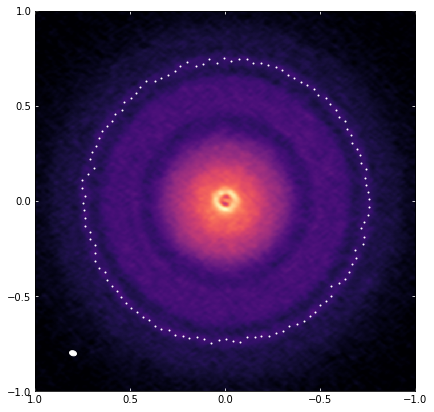

In [27]:
# Extract the ring that's at ~45 AU
xcoords3, ycoords3 = cont.extract_ring(42,48,tbins = -178.5+3*np.arange(120), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords3, ycoords3, 1.0, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_3 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     45/60., 
                     np.log(.01**2)], 
                    xcoords3, ycoords3,
                    np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180.)

In [44]:
sampler3 = run_mcmc(nwalkers, nthreads, nsteps, mle_3, lnprob, xcoords3, ycoords3, np.cos(7*np.pi/180.), 155*np.pi/180.)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anacond

In [45]:
np.savez("TWHyaellipsechains.npz", DA26 = sampler1.chain, DA42 = sampler2.chain, BR45 = sampler3.chain)

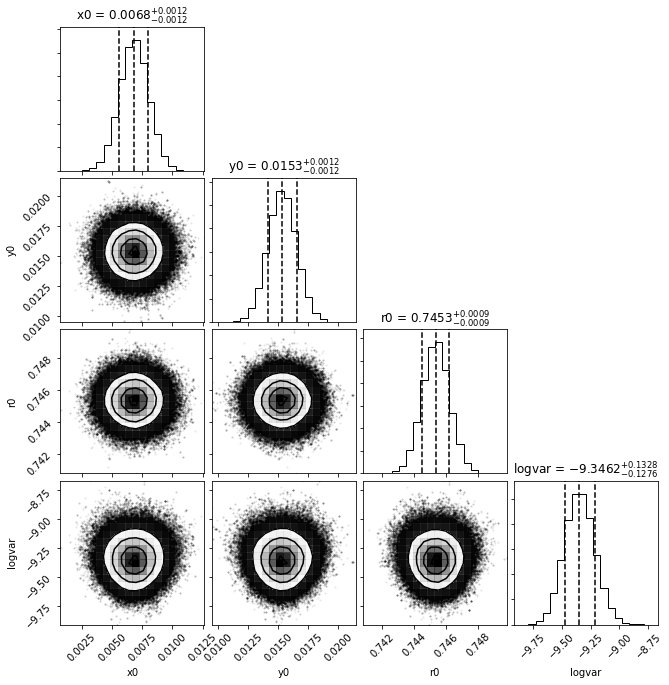

The x offset is delta_x = 6.82e-03 arcsec (+1.2e-03, -1.2e-03)
The y offset is delta_y = 1.53e-02 arcsec (+1.2e-03, -1.2e-03)
The median semi-major axis is r = 0.7453 arcsec (+0.0009, -0.0009) 
or 44.72 AU (+0.07, -0.07)
The median log-variance in the pixel offsets from the true ellipse is -9.346e+00


In [46]:
plot_corner(sampler3, 1000, 1)
sampler_results(sampler3, 1000, cont.src_distance)

In [4]:

#make some preliminary plots
maxrad = 100
radialbins = 0.25+0.5*np.arange(2*maxrad)
newcont = Continuum(disk['filename'], 0.0076,0.0144, 155, 7,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [5, 58, 66, 89, 98, 150, 157, 162, 170, 179, 183, 190, 194]
min [2, 51, 63, 83, 97, 150, 157, 159, 164, 176, 181, 188, 192, 198]


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


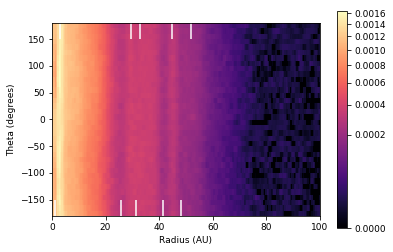

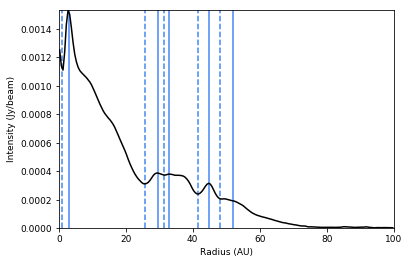

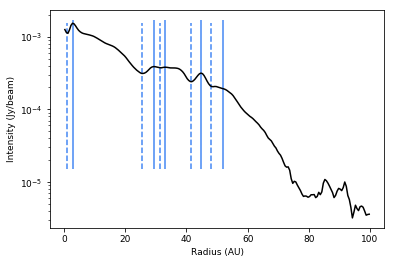

(0, 100)

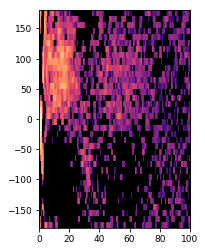

In [5]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.2, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
rings = np.array([3, 29.5, 33, 44.72,52])
gaps = np.array([1,25.6, 31.5, 41.64,48])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),1.0*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),1.1*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,0.01*np.max(newsurfbrightness),1.0*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,0.01*np.max(newsurfbrightness),1.1*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-newsurfbrightness,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)


In [6]:
Imean = 0.5*(np.max(newsurfbrightness)+newsurfbrightness[2])
print(np.argmin(np.abs(Imean-newsurfbrightness[2:5]))+2)
print(np.argmin(np.abs(Imean-newsurfbrightness[5:]))+5)
(radialbins[8]-radialbins[3])

3
8


2.5

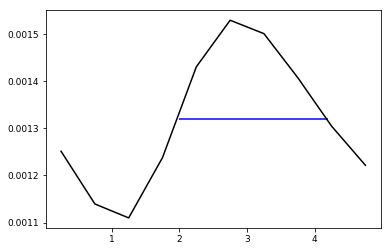

In [12]:
plt.plot(radialbins[:10], newsurfbrightness[:10], color = 'black')
plt.hlines(Imean, 2.0,4.2, color = 'blue')

In [13]:
measure_widths(25.62, 29.5, radialbins, newsurfbrightness, 0, 40)

0.000349421941578 27.6


(4.0, 10.5)

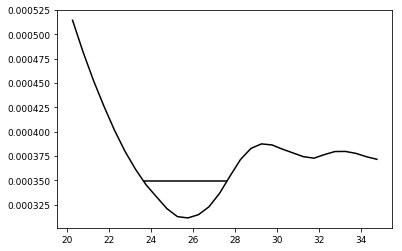

In [17]:
plt.plot(radialbins[40:70], newsurfbrightness[40:70], color = 'black')
plt.hlines(0.000349421941578,27.6-4.0, 27.6)


In [44]:
calc_contrast(31.5, 33, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.9861009334680183, 0.0083528997819550463)

In [51]:
calc_contrast(41.64, 44.72, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.76273772244546978, 0.0085974831911388595)

In [20]:
measure_widths(41.64, 44.72, radialbins, newsurfbrightness,35, 80)

0.000277555006094 43.3


(3.3999999999999986, 2.7999999999999972)

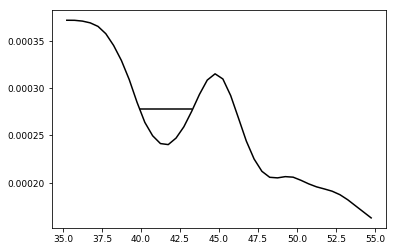

In [22]:
plt.plot(radialbins[70:110], newsurfbrightness[70:110], color = 'black')
plt.hlines(0.000277555006094,43.3-3.4, 43.3)

67.5


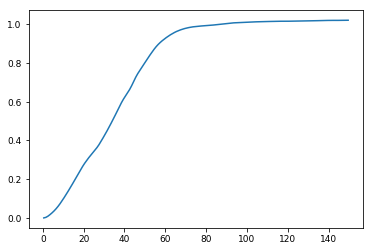

In [10]:
bins = 0.5+1*np.arange(0, 150)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])